In [1]:
# pip install sodapy; pip install us;

In [2]:
import pandas as pd
from sodapy import Socrata
import requests as rq
import matplotlib.pyplot as plt
import us

In [3]:
# Enrollment data by state
# Source: https://www.kff.org/health-reform/state-indicator/medicaid-expansion-enrollment/?currentTimeframe=0&sortModel=%7B%22colId%22:%22Location%22,%22sort%22:%22asc%22%7D

df_medicaid = pd.read_csv('data/KFF_medicaid_enrollment.csv', header=2).loc[:51] # get rid of junk rows
df_medicaid = df_medicaid[~df_medicaid['Location'].isin(['United States', 'District of Columbia'])].reset_index()
df_medicaid = df_medicaid.rename(columns={
    'Location':'state',
    'Expanded by September 30th, 2022':'expanded_medicaid'
})
df_medicaid['expanded_medicaid'] = df_medicaid['expanded_medicaid'].replace({'Yes': True, 'No': False})
df_medicaid = df_medicaid[['state', 'expanded_medicaid']]

state_abbrs = []
for s in df_medicaid['state']:
    state_obj = us.states.lookup(s)
    state_abbrs.append(us.states.lookup(s).abbr)
df_medicaid['state_abbr'] = state_abbrs

df_medicaid.head()

,state,expanded_medicaid,state_abbr
0,Alabama,False,AL
1,Alaska,True,AK
2,Arizona,True,AZ
3,Arkansas,True,AR
4,California,True,CA


In [4]:
# ER data by state
# Source: https://www.kff.org/other/state-indicator/emergency-room-visits-by-ownership/?currentTimeframe=0&sortModel=%7B%22colId%22:%22Location%22,%22sort%22:%22asc%22%7D

df_er = pd.read_csv('data/KFF_ER_visits.csv', header=2).loc[:51] # get rid of junk rows
df_er = df_er[~df_er['Location'].isin(['United States', 'District of Columbia'])]
df_er = df_er.rename(columns={
    'Location':'state',
    'Total':'er_visits'
})
df_er = df_er.sort_values('er_visits', ascending=False).reset_index()
df_er = df_er.loc[:, ['state', 'er_visits']]

df_er.head()

,state,er_visits
0,Maine,596.0
1,Louisiana,535.0
2,Kentucky,525.0
3,West Virginia,524.0
4,Ohio,505.0


In [5]:
# maternal deaths per 100,000 live births by state
# Source: https://www.kff.org/other/state-indicator/maternal-deaths-and-mortality-rates-per-100000-live-births/?currentTimeframe=0&sortModel=%7B%22colId%22:%22Location%22,%22sort%22:%22asc%22%7D

df_mat_deaths = pd.read_csv('data/KFF_maternal_deaths.csv', header=2).loc[:51] # get rid of junk rows
df_mat_deaths = df_mat_deaths[~df_mat_deaths['Location'].isin(['United States', 'District of Columbia'])]
df_mat_deaths = df_mat_deaths.rename(columns={
    'Location':'state',
    'Maternal Mortality Rate per 100,000 live Births':'deaths_per_100k'
})
df_mat_deaths = df_mat_deaths.loc[df_mat_deaths['deaths_per_100k'] != 'NR',:]
df_mat_deaths['deaths_per_100k'] = df_mat_deaths['deaths_per_100k'].astype(float)
df_mat_deaths = df_mat_deaths.sort_values('deaths_per_100k', ascending=False).reset_index()
df_mat_deaths = df_mat_deaths.loc[:, ['state', 'deaths_per_100k']]

df_mat_deaths.head()

,state,deaths_per_100k
0,Arkansas,40.4
1,Kentucky,39.7
2,Alabama,36.2
3,Tennessee,34.6
4,Louisiana,31.8


In [6]:
df_life_exp = pd.read_csv('data/cdc_life_exp.csv')
df_life_exp = df_life_exp.rename(columns={'STATE':'state_abbr', 'RATE':'life_exp'})

df_life_exp = df_life_exp.loc[df_life_exp['YEAR'] == max(df_life_exp['YEAR'])]
state_names = []
for s in df_life_exp['state_abbr']:
    state_names.append(us.states.lookup(s).name)
df_life_exp['state'] = state_names
df_life_exp = df_life_exp[['state', 'life_exp']]
df_life_exp = df_life_exp.sort_values('life_exp').reset_index().drop(columns='index')

df_life_exp.head()

,state,life_exp
0,Mississippi,71.9
1,West Virginia,72.8
2,Louisiana,73.1
3,Alabama,73.2
4,Kentucky,73.5


In [7]:
# API endpoint URL for poverty rate data by state
url = 'https://api.census.gov/data/timeseries/poverty/saipe?get=NAME,SAEPOVRTALL_PT&for=state:*&time=2021'

response = rq.get(url)
data = response.json()
cols = data[0]

df_poverty = pd.DataFrame(data[1:], columns=cols)
df_poverty = df_poverty.rename(columns={'NAME':'state',
                                        'SAEPOVRTALL_PT':'poverty_rate',
                                        'state':'state_num'})
df_poverty['poverty_rate'] = df_poverty['poverty_rate'].astype(float)
df_poverty = df_poverty.sort_values('poverty_rate', ascending=False).reset_index()[['state','poverty_rate']]

df_poverty.head()

,state,poverty_rate
0,Louisiana,19.5
1,Mississippi,19.2
2,New Mexico,17.7
3,District of Columbia,16.8
4,West Virginia,16.8


In [8]:
def make_plot(df, y_col, y_lbl, title):
    df = df.merge(df_medicaid, how='inner', on='state')
    
    plt.figure(figsize=(12, 3))
    plt.grid(True)
    for i in range(len(df)):
        if df.loc[i, 'expanded_medicaid']:
            plt.scatter(i, df[y_col][i], c='#30b5f2', marker='o', zorder=100)
        else:
            plt.scatter(i, df[y_col][i], c='#eb4034', marker='D', zorder=100)
    plt.xticks(range(len(df)), df['state_abbr'], rotation='horizontal', fontsize=8)

    plt.xlabel('State')
    plt.ylabel(y_lbl)
    plt.title(title)
    plt.axvline(x=len(df)/2, color='green', linestyle='-')
    plt.tick_params(axis='x', which='both', direction='in')
    plt.grid(True)
    plt.show()

# How are quality-of-life metrics in states that haven't adopted the ACA Medicaid expansion?

In 2010, the Affordable Care Act (ACA) gave states the option to expand Medicaid eligibility to a larger proportion of their populations in order to fill the "Medicaid coverage gap" - people with incomes too high to qualify for pre-ACA Medicaid, but too low to qualify for subsidized plans through the insurance marketplace.

As of June 2023, 38 states have implemented the Medicaid expansion and 12 states have not (including NC and SD, who have adopted but not yet implemented). I was curious to see if there were any patterns in the states that have not, with respect to common quality-of-life statistics.

I've chosen to examine four such metrics...
- Life Expectancy
- Poverty Rate
- ER Visits
- Maternal Mortality

...and see where the states who haven't implemented Medicaid expansion stack up. On the charts below, the blue dot signifies a Medicaid expansion state and the red diamond symbol signifies a non-expansion state. The green line is an indicator for the median, so states to the left perform worse and states to the right perform better.

This is not intended to be a rigorous statistical analysis - merely a visualization to show if non-expansion states tend to fall above or below the median. This is also not intended to attribute a state's lack of Medicaid expansion to worse outcomes (or vise versa). For example, rural states tend to be more politically conservative on average, and the ruralness may also (independently) contribute to challenges with these quality-of-life indicators.

Sources:
https://en.wikipedia.org/wiki/Medicaid_coverage_gap

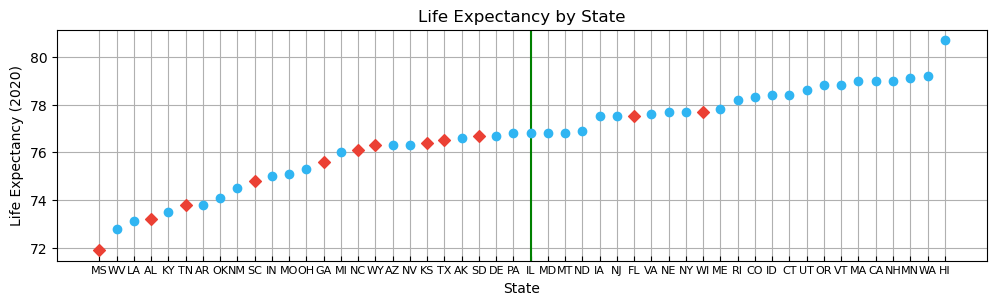

In [13]:
make_plot(df_life_exp, 'life_exp', 'Life Expectancy (2020)', 'Life Expectancy by State')

For life expectancy, non-expansion states tend to underperform by a significant margin. 10 of the 12 fall below the median and only 2 are above (Florida and Wisconsin).

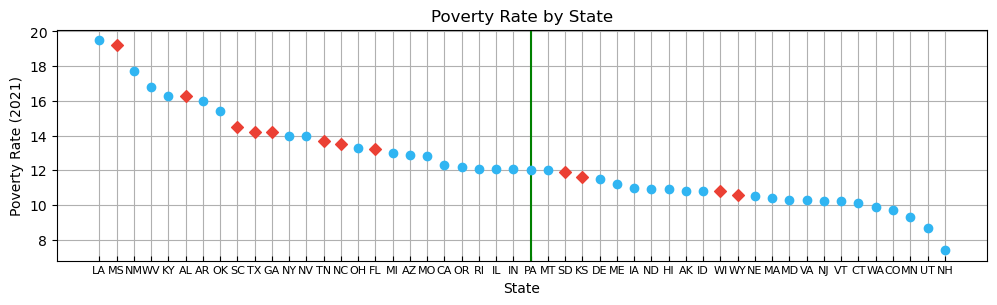

In [10]:
make_plot(df_poverty, 'poverty_rate', 'Poverty Rate (2021)', 'Poverty Rate by State')

A similar pattern emerges with poverty rate, but it's slightly less pronounced. 8 of the 12 non-expansion states are below the median and 4 are above.

Source: https://www.census.gov/data/developers/data-sets/Poverty-Statistics.html

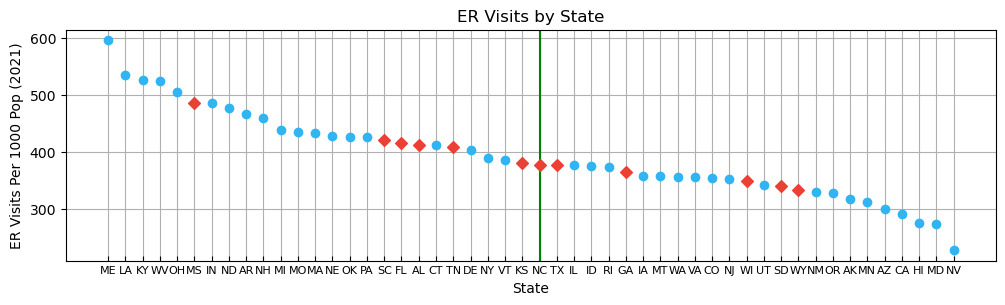

In [11]:
make_plot(df_er, 'er_visits', 'ER Visits Per 1000 Pop (2021)', 'ER Visits by State')

Somewhat to my surprise, there appears to be almost no correlation between ER visits per 1000 and whether or not a state hasn't expanded Medicaid. 6 of the non-expansion states are above the median, 5 are above, and 1 is at the median (North Carolina). I became curious why Maine of all places has such a high rate of ER visits, and this (somewhat outdated) article from a local news outlet offers a few clues, including Maine's standing as a state with one of the oldest populations:
https://www.newscentermaine.com/article/news/local/maine-ranks-4th-in-nation-for-emergency-room-visits-per-capita/97-609930567

Source: https://www.kff.org/other/state-indicator/emergency-room-visits-by-ownership/?currentTimeframe=0&sortModel=%7B%22colId%22:%22Location%22,%22sort%22:%22asc%22%7D

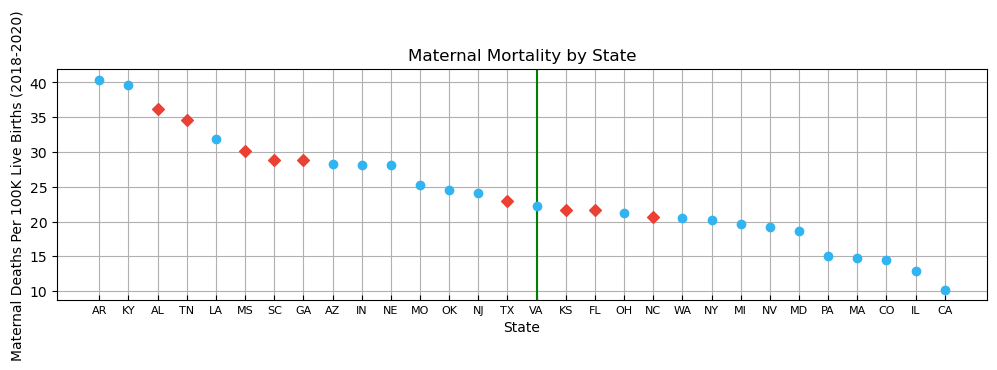

In [12]:
make_plot(df_mat_deaths, 'deaths_per_100k', 'Maternal Deaths Per 100K Live Births (2018-2020)', 'Maternal Mortality by State')

Finally, maternal mortality follows a similar pattern as the first two metrics. A number of states had their data suppressed "due to reliability and confidentiality restrictions," including 3 of the 12 non-expansion states, so we're only left with 9. 6 of those 9 states underperform when it comes to maternal deaths, and 3 states fall above the median.

Source: https://www.kff.org/other/state-indicator/maternal-deaths-and-mortality-rates-per-100000-live-births/?currentTimeframe=0&sortModel=%7B%22colId%22:%22Location%22,%22sort%22:%22asc%22%7D